<div align="left">
    <strong>Scanpy Workflow: Preprocessing and clustering</strong>
</div>


![alt text](https://scanpy.readthedocs.io/en/stable/_static/Scanpy_Logo_BrightFG.svg)

### Installation

In [194]:
#!pip install scanpy
#!conda install -y -c anaconda cmake 
#!pip install leidenalg
#!pip install louvain
#!conda install -c conda-forge cmake -y
#!pip install louvain --use-pep517

In [63]:
#!pip uninstall louvain -y

### Importing The Libraries

In [65]:
import scanpy as sc
import pandas as pd
import numpy as np
import leidenalg
#import louvain
import leidenalg
import louvain
print("Libraries installed successfully!")

Libraries installed successfully!


/tmp/ipykernel_24043/2973170261.py:7: DeprecationWarning: This package has been superseded by the `leidenalg` package and will no longer be maintained. Please upgrade to the `leidenalg` package.
  import louvain


### Check The Installation

In [67]:
print(sc.__version__, '\n', np.__version__, '\n', pd.__version__)

1.10.3 
 1.26.4 
 2.2.2


In [68]:
sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor="white")

scanpy==1.10.3 anndata==0.10.9 umap==0.5.6 numpy==1.26.4 scipy==1.13.1 pandas==2.2.2 scikit-learn==1.4.2 statsmodels==0.14.2 igraph==0.11.6 louvain==0.8.2 pynndescent==0.5.13


**To save the Results**

In [70]:
results_file = "write/pbmc3k.h5ad"  # the file that will store the analysis results

### Dataset 

In [72]:
!mkdir -p data
!curl https://cf.10xgenomics.com/samples/cell-exp/1.1.0/pbmc3k/pbmc3k_filtered_gene_bc_matrices.tar.gz -o data/pbmc3k_filtered_gene_bc_matrices.tar.gz
!cd data; tar -xzf pbmc3k_filtered_gene_bc_matrices.tar.gz
!mkdir -p write

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 7443k  100 7443k    0     0  5039k      0  0:00:01  0:00:01 --:--:-- 5042k


In [73]:
adata = sc.read_10x_mtx(
    "data/filtered_gene_bc_matrices/hg19/",  # the directory with the `.mtx` file
    var_names="gene_symbols",  # use gene symbols for the variable names (variables-axis index)
    cache=True,  # write a cache file for faster subsequent reading
)

... reading from cache file cache/data-filtered_gene_bc_matrices-hg19-matrix.h5ad


In [74]:
adata

AnnData object with n_obs × n_vars = 2700 × 32738
    var: 'gene_ids'

**Preprocessing:** Show those genes that yield the highest fraction of counts in each single cell, across all cells.

normalizing counts per cell
    finished (0:00:00)


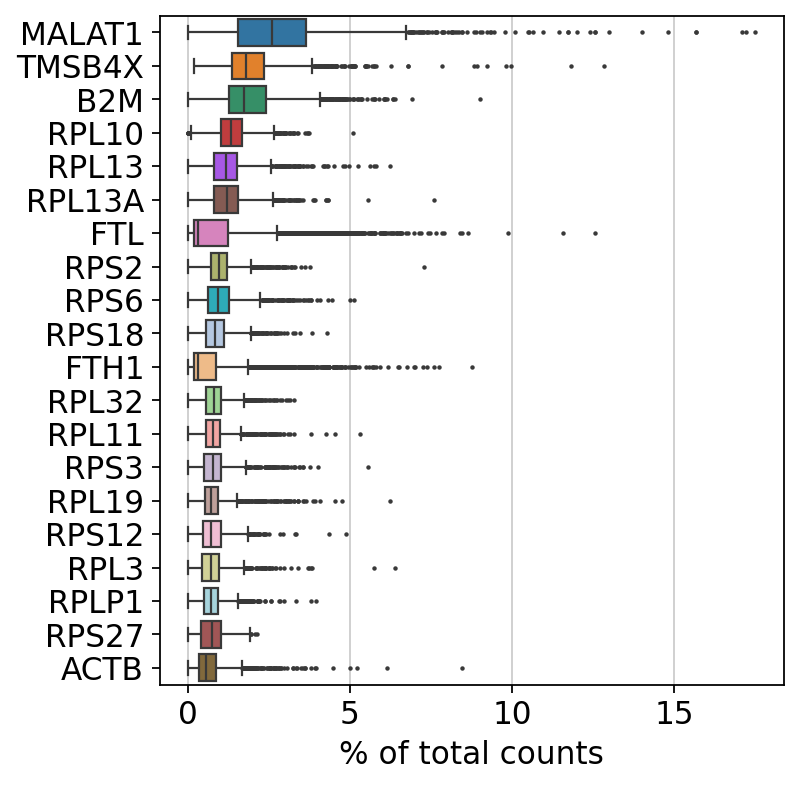

In [76]:
sc.pl.highest_expr_genes(adata, n_top=20)

#### Basic filtering:

In [78]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

filtered out 19024 genes that are detected in less than 3 cells


With `pp.calculate_qc_metrics`, we can compute many metrics very efficiently.

In [80]:
# annotate the group of mitochondrial genes as "mt"
adata.var["mt"] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt"], percent_top=None, log1p=False, inplace=True
)

**A violin plot of some of the computed quality measures:**
- the number of genes expressed in the `count matrix`
- the total `counts` per cell
- the percentage of counts in `mitochondrial genes` [MT]

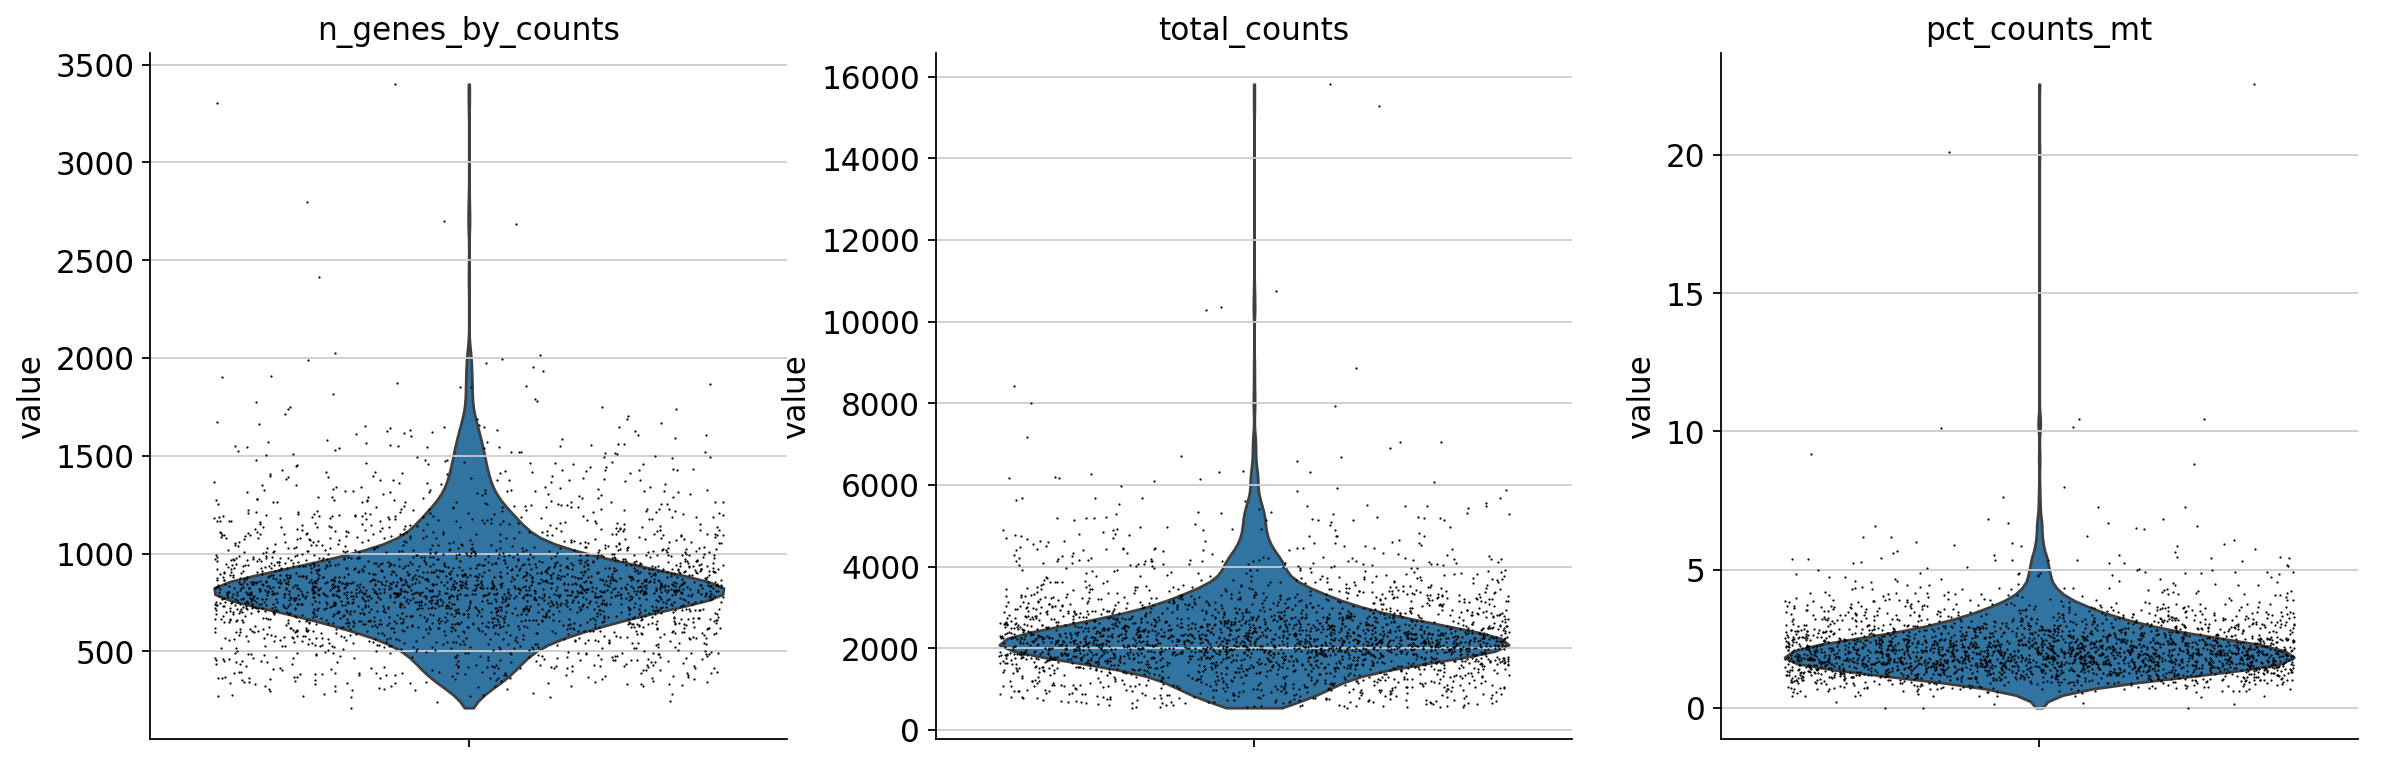

In [82]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

**Remove cells that have too many mitochondrial genes expressed or too many total counts:**

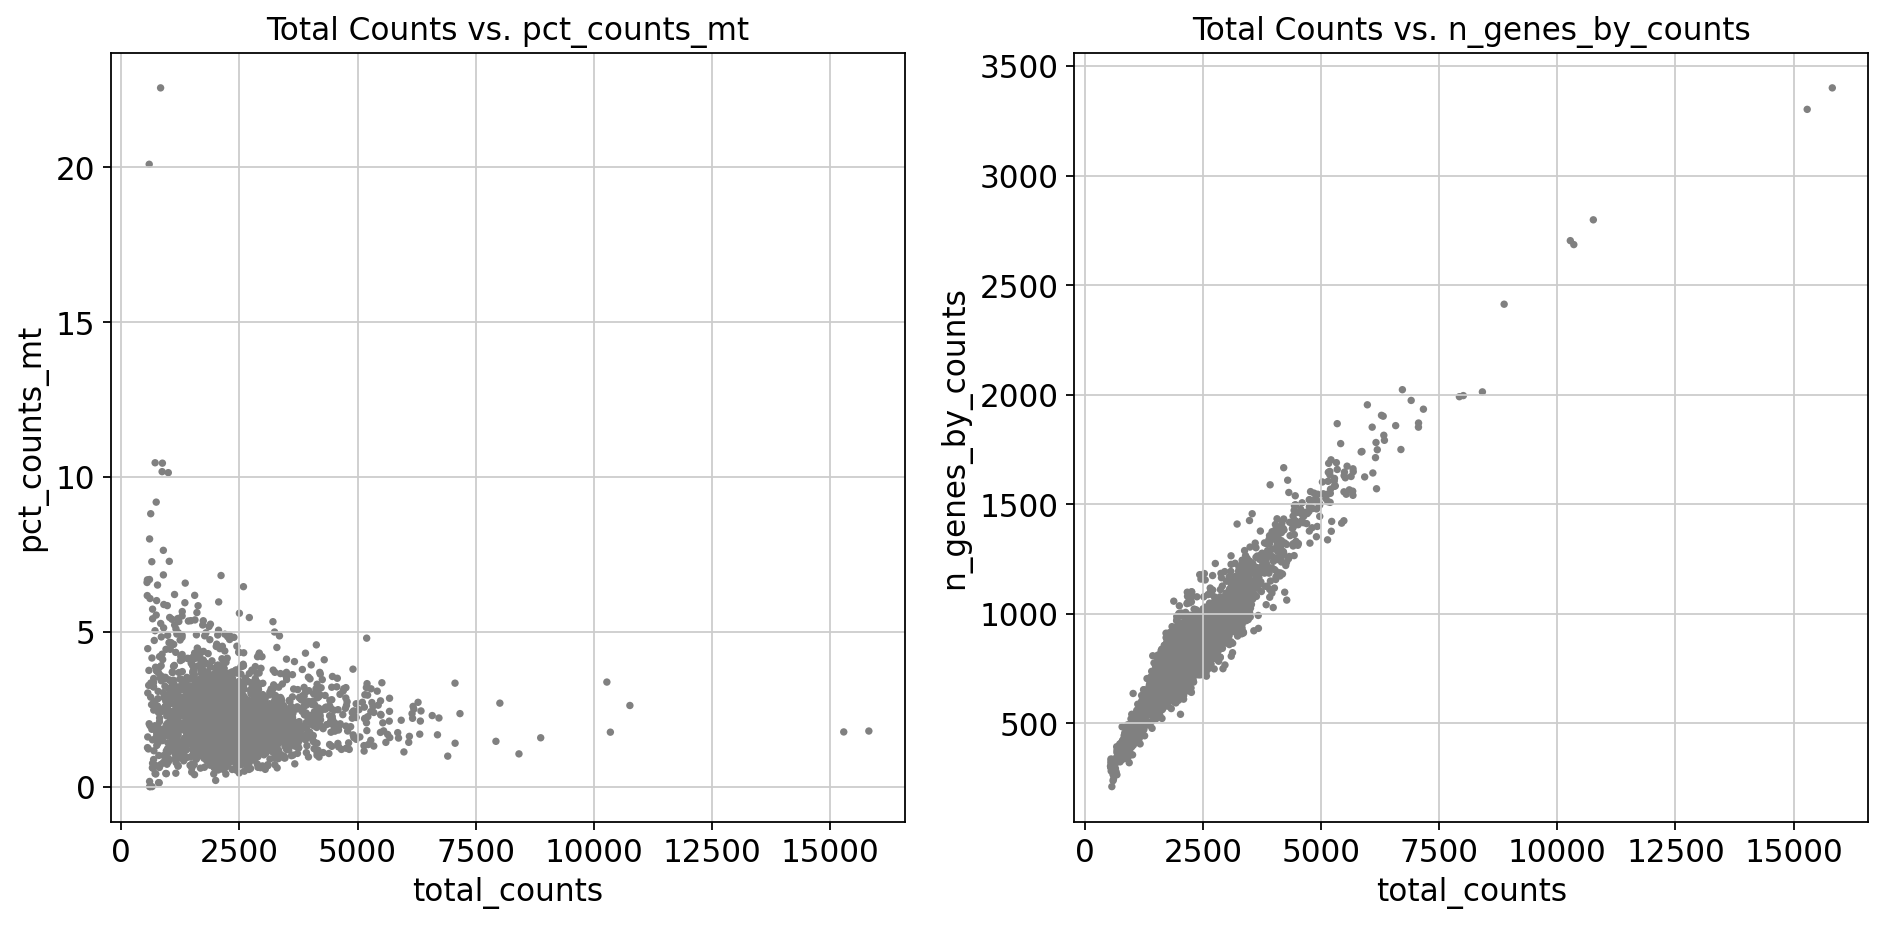

In [84]:
#sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt")
#sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts")

import matplotlib.pyplot as plt

# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# First plot: total counts vs. percentage of mitochondrial counts
sc.pl.scatter(adata, x="total_counts", y="pct_counts_mt", ax=axes[0], show=False)
axes[0].set_title('Total Counts vs. pct_counts_mt')

# Second plot: total counts vs. number of genes by counts
sc.pl.scatter(adata, x="total_counts", y="n_genes_by_counts", ax=axes[1], show=False)
axes[1].set_title('Total Counts vs. n_genes_by_counts')

# Adjust the layout and display the plots
plt.tight_layout()
plt.show()

In [85]:
# Actually do the filtering by slicing the AnnData object.
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

Total-count normalize (library-size correct) the data matrix $\mathbf{X}$ to 10,000 reads per cell, so that counts become comparable among cells.

In [87]:
sc.pp.normalize_total(adata, target_sum=1e4)

normalizing counts per cell
    finished (0:00:00)


#### Logarithmize the data:

In [89]:
sc.pp.log1p(adata)

#### Identify highly-variable genes.

In [91]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)

extracting highly variable genes
    finished (0:00:00)
--> added
    'highly_variable', boolean vector (adata.var)
    'means', float vector (adata.var)
    'dispersions', float vector (adata.var)
    'dispersions_norm', float vector (adata.var)


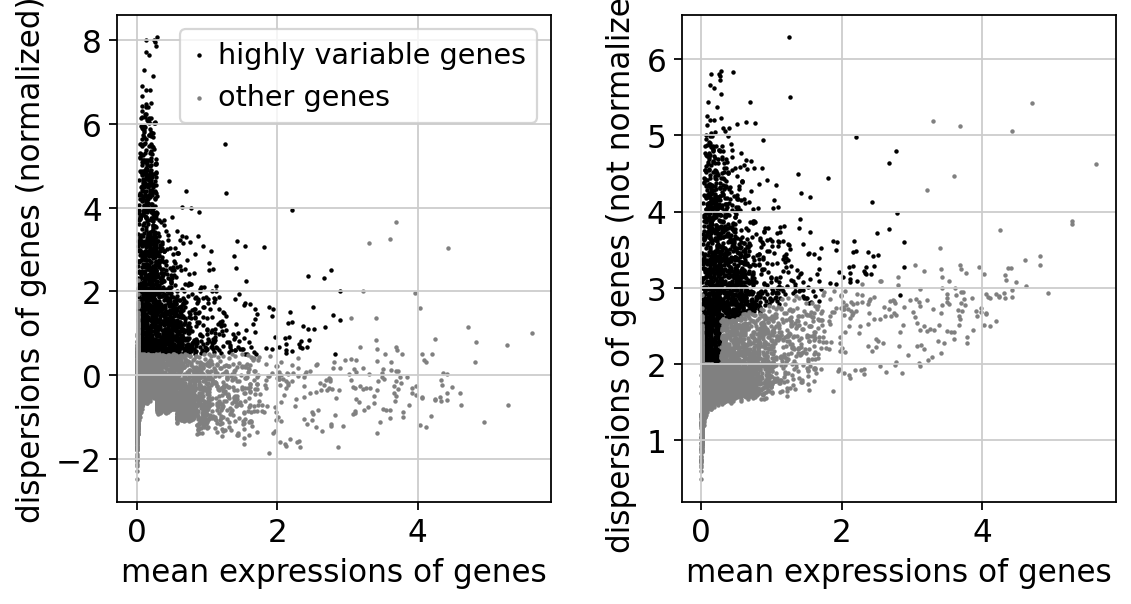

In [92]:
sc.pl.highly_variable_genes(adata)

Set the `.raw` attribute of the AnnData object to the normalized and logarithmized raw gene expression for later use in differential testing and visualizations of gene expression. This freezes the state of the AnnData object.

In [94]:
adata.raw = adata.copy()

In [95]:
adata = adata[:, adata.var.highly_variable]

Regress out effects of total counts per cell and the percentage of mitochondrial genes expressed. Scale the data to unit variance.

In [97]:
sc.pp.regress_out(adata, ["total_counts", "pct_counts_mt"])

regressing out ['total_counts', 'pct_counts_mt']
    sparse input is densified and may lead to high memory use


/home/mahendra/anaconda3/lib/python3.12/site-packages/scanpy/preprocessing/_simple.py:668: UserWarning: Received a view of an AnnData. Making a copy.
  view_to_actual(adata)


    finished (0:00:04)


Scale each gene to unit variance. Clip values exceeding standard deviation 10

In [99]:
sc.pp.scale(adata, max_value=10)

**Principal component analysis:** Reduce the dimensionality of the data by running principal component analysis (PCA), which reveals the main axes of variation and denoises the data.

In [101]:
sc.tl.pca(adata, svd_solver="arpack")

computing PCA
    with n_comps=50
    finished (0:00:01)


We can make a **scatter plot** for the PCA coordinates

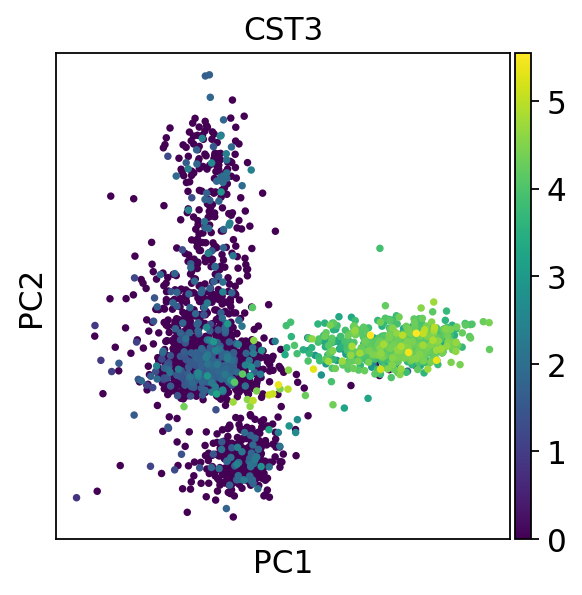

In [103]:
sc.pl.pca(adata, color="CST3")

Let us inspect the contribution of single PCs to the total variance in the data. This gives us information about how many PCs we should consider in order to compute the neighborhood relations of cells, e.g. used in the clustering function `sc.tl.louvain()` or tSNE `sc.tl.tsne().`

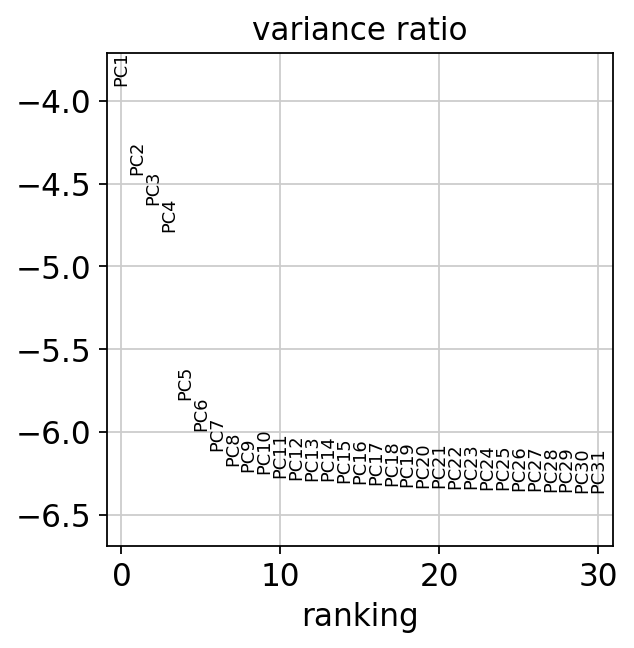

In [105]:
sc.pl.pca_variance_ratio(adata, log=True)

In [106]:
adata.write(results_file)

In [107]:
#adata

**Computing the neighborhood graph**

In [109]:
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)

computing neighbors
    using 'X_pca' with n_pcs = 40
    finished: added to `.uns['neighbors']`
    `.obsp['distances']`, distances for each pair of neighbors
    `.obsp['connectivities']`, weighted adjacency matrix (0:00:01)


In [120]:
sc.tl.paga(adata)
sc.pl.paga(adata, plot=False)  # remove `plot=False` if you want to see the coarse-grained graph
sc.tl.umap(adata, init_pos='paga')

running PAGA
    finished: added
    'paga/connectivities', connectivities adjacency (adata.uns)
    'paga/connectivities_tree', connectivities subtree (adata.uns) (0:00:00)
--> added 'pos', the PAGA positions (adata.uns['paga'])
computing UMAP
    finished: added
    'X_umap', UMAP coordinates (adata.obsm)
    'umap', UMAP parameters (adata.uns) (0:00:02)


**The raw (normalized, logarithmized, but uncorrected) gene expression**

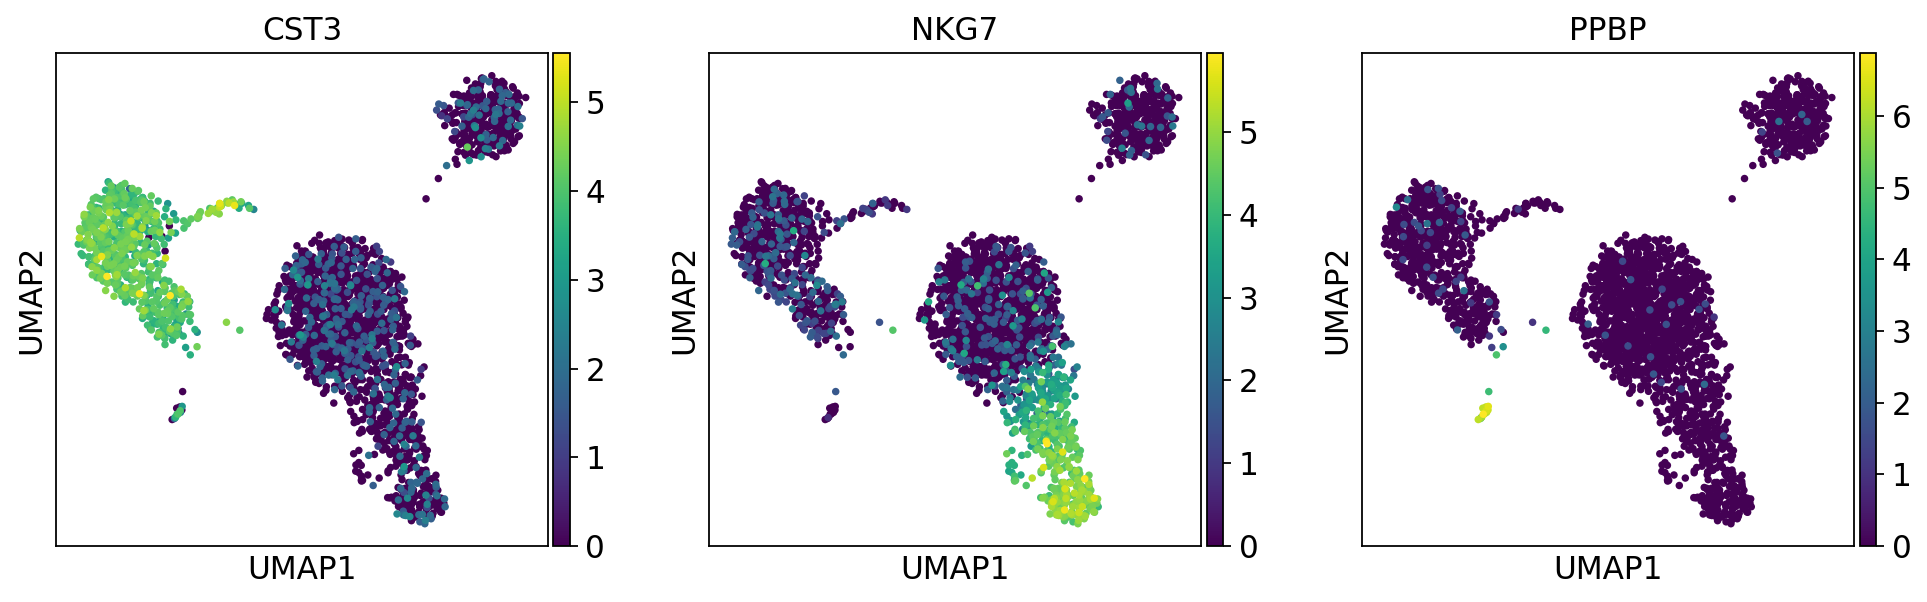

In [122]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"])

**plot the scaled and corrected gene expression by explicitly stating that you don’t want to use `.raw`**`

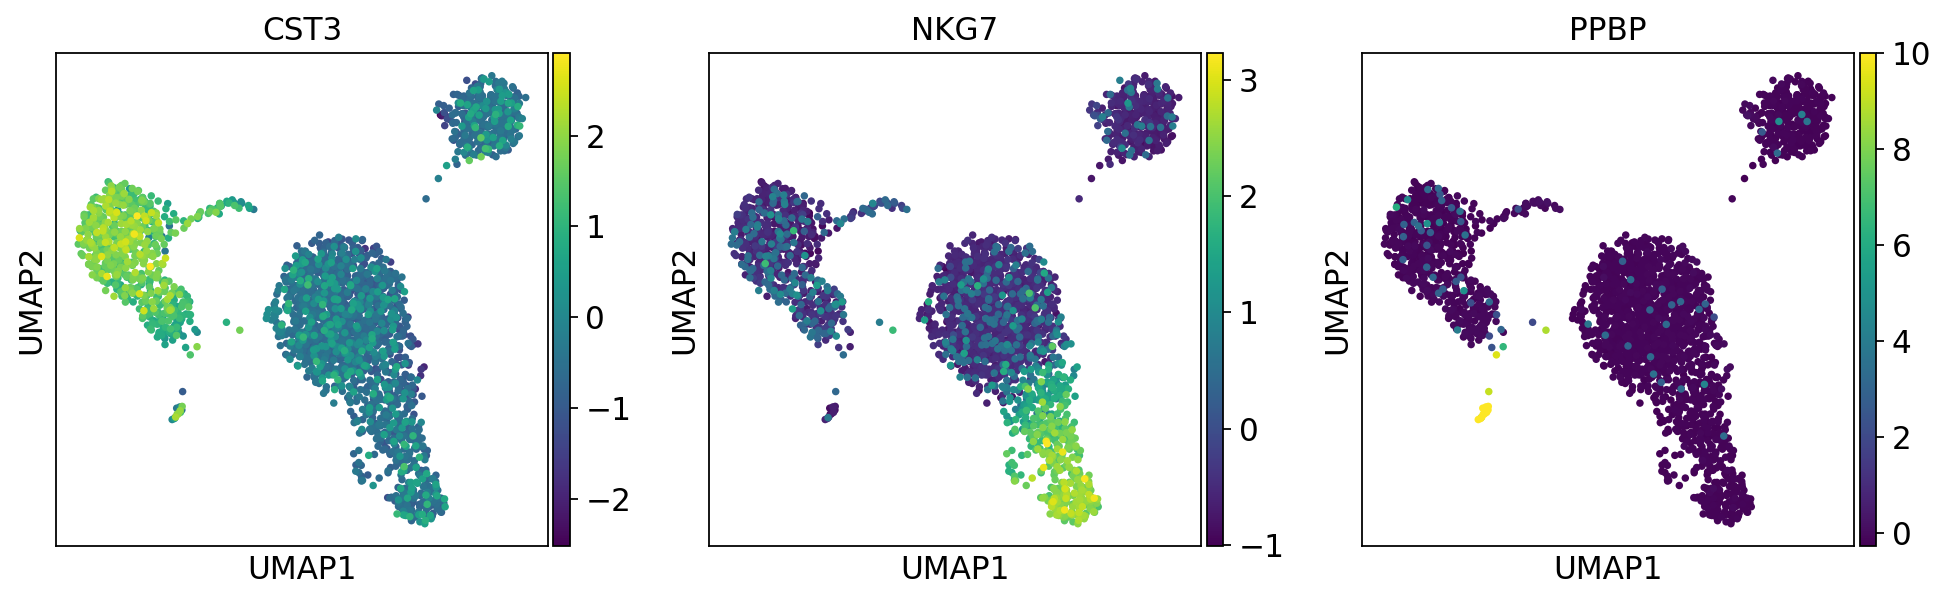

In [127]:
sc.pl.umap(adata, color=["CST3", "NKG7", "PPBP"], use_raw=False)

**Clustering the neighborhood graph**

In [130]:
sc.tl.leiden(
    adata,
    resolution=0.9,
    random_state=0,
    flavor="igraph",
    n_iterations=2,
    directed=False,
)

running Leiden clustering
    finished: found 8 clusters and added
    'leiden', the cluster labels (adata.obs, categorical) (0:00:00)


**Plot** the clusters, which agree quite well with the result of `Seurat`.

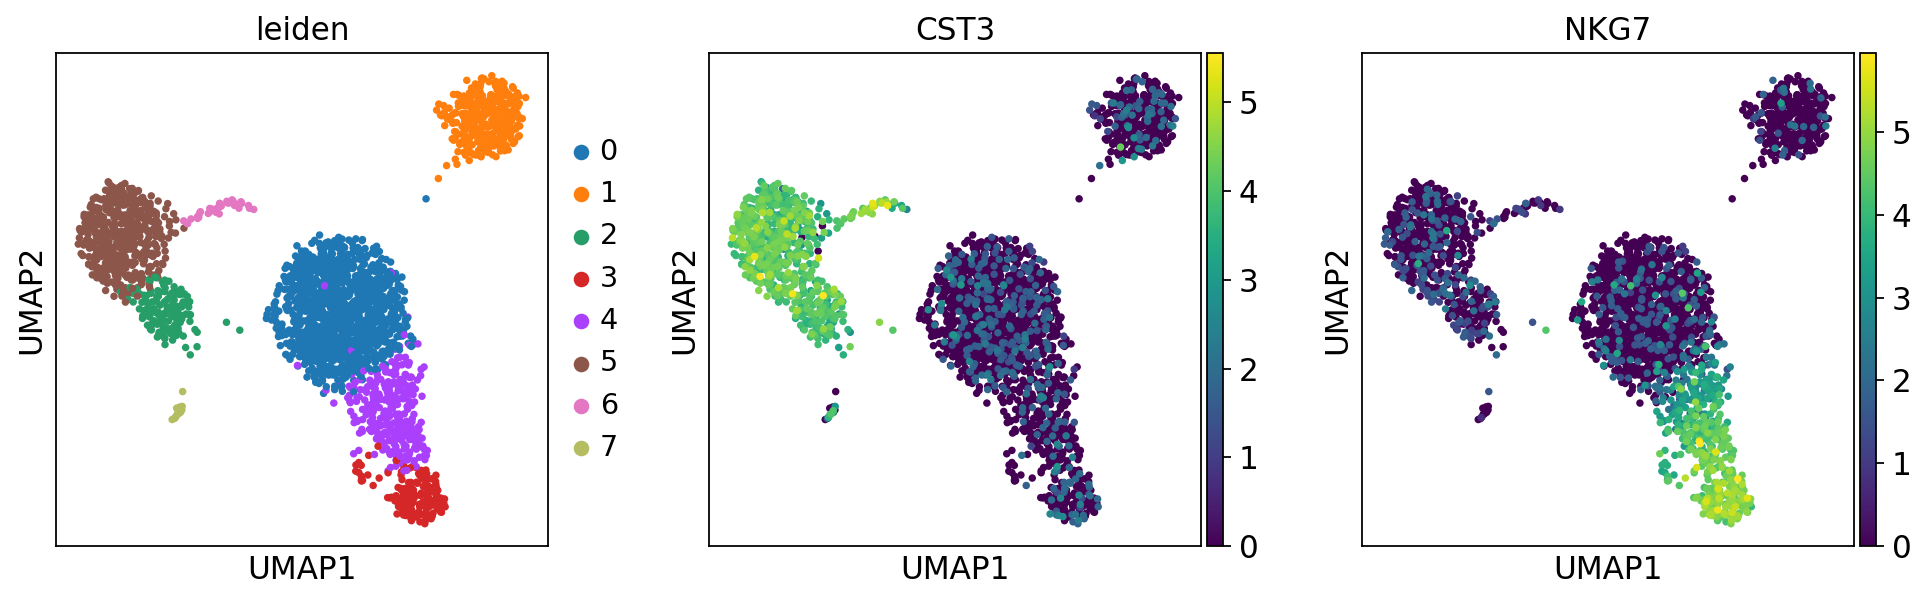

In [135]:
sc.pl.umap(adata, color=["leiden", "CST3", "NKG7"])

In [137]:
adata.write(results_file)

**Finding marker genes**: Let us compute a ranking for the highly differential genes in each cluster. For this, by default, the `.raw` attribute of AnnData is used in case it has been initialized before. The simplest and fastest method to do so is the t-test.


**Ranking genes using the t-test and Wilcoxon rank-sum (Mann-Whitney-U) test**

ranking genes
    finished: added to `.uns['rank_genes_groups']`
    'names', sorted np.recarray to be indexed by group ids
    'scores', sorted np.recarray to be indexed by group ids
    'logfoldchanges', sorted np.recarray to be indexed by group ids
    'pvals', sorted np.recarray to be indexed by group ids
    'pvals_adj', sorted np.recarray to be indexed by group ids (0:00:00)


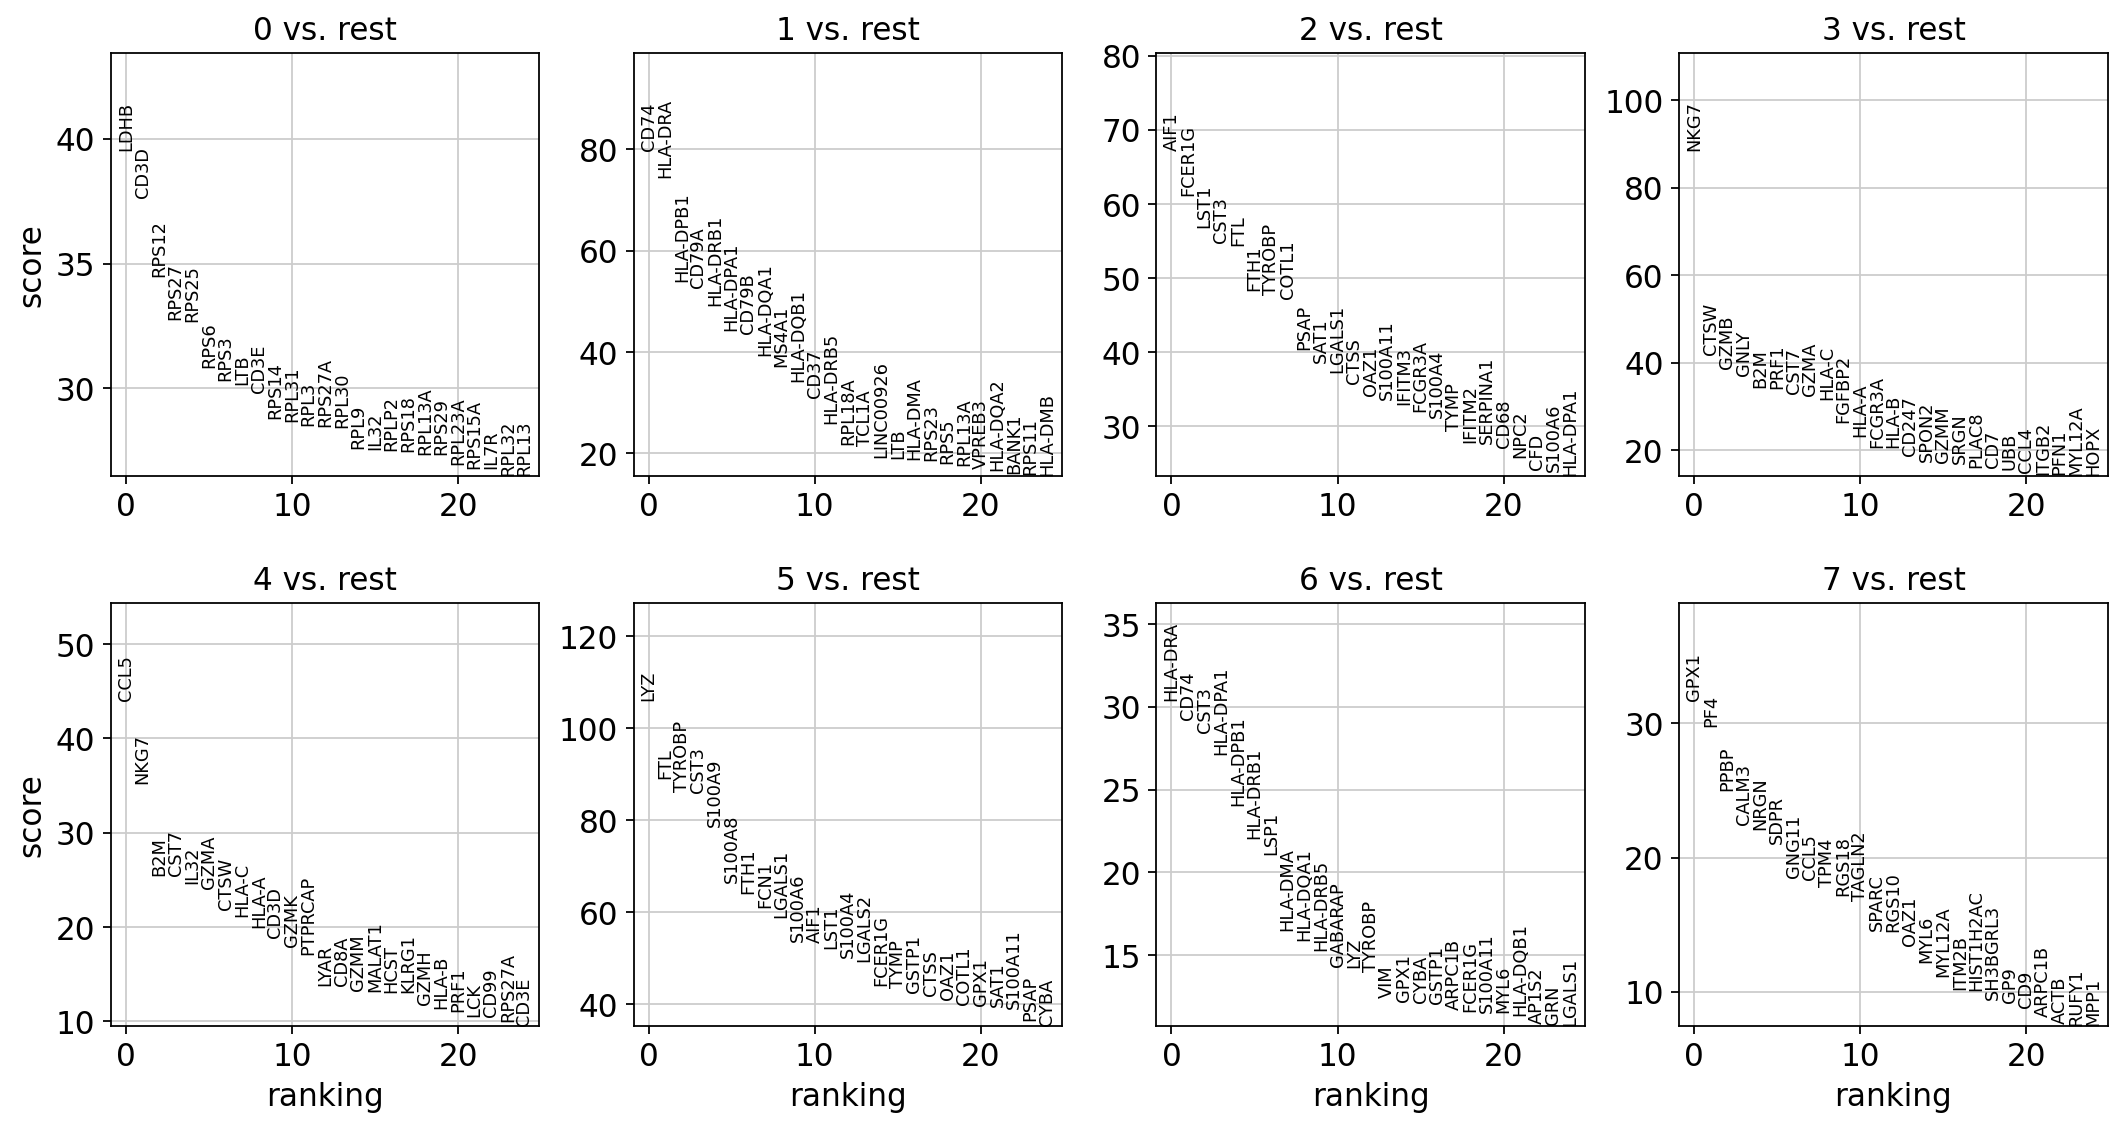

In [141]:
sc.tl.rank_genes_groups(adata, "leiden", method="t-test")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [143]:
sc.settings.verbosity = 2  # reduce the verbosity

ranking genes
    finished (0:00:02)


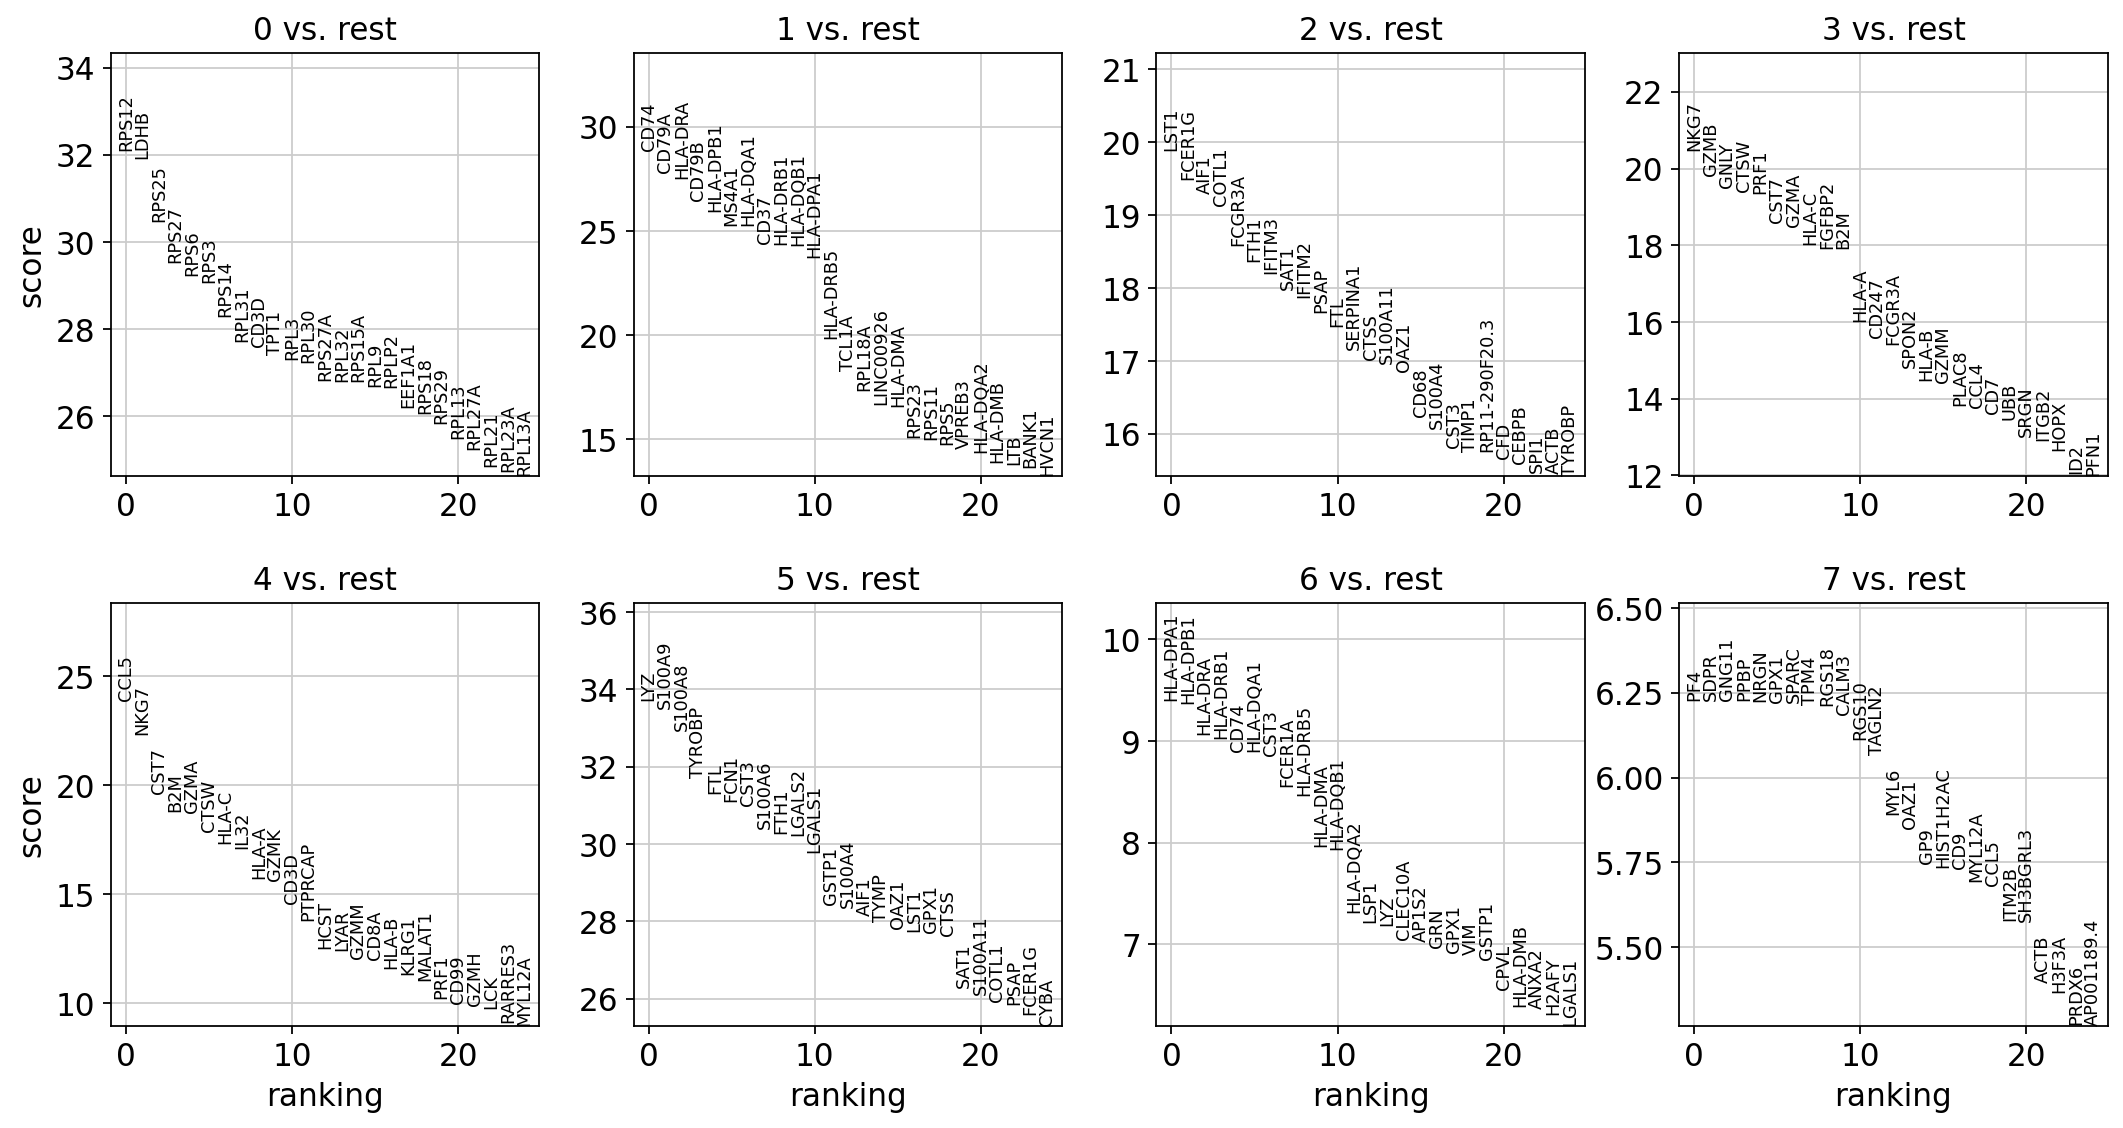

In [145]:
sc.tl.rank_genes_groups(adata, "leiden", method="wilcoxon")
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

In [150]:
adata.write(results_file)

**As an alternative, let us rank genes using `logistic regression`**

ranking genes
    finished (0:00:01)


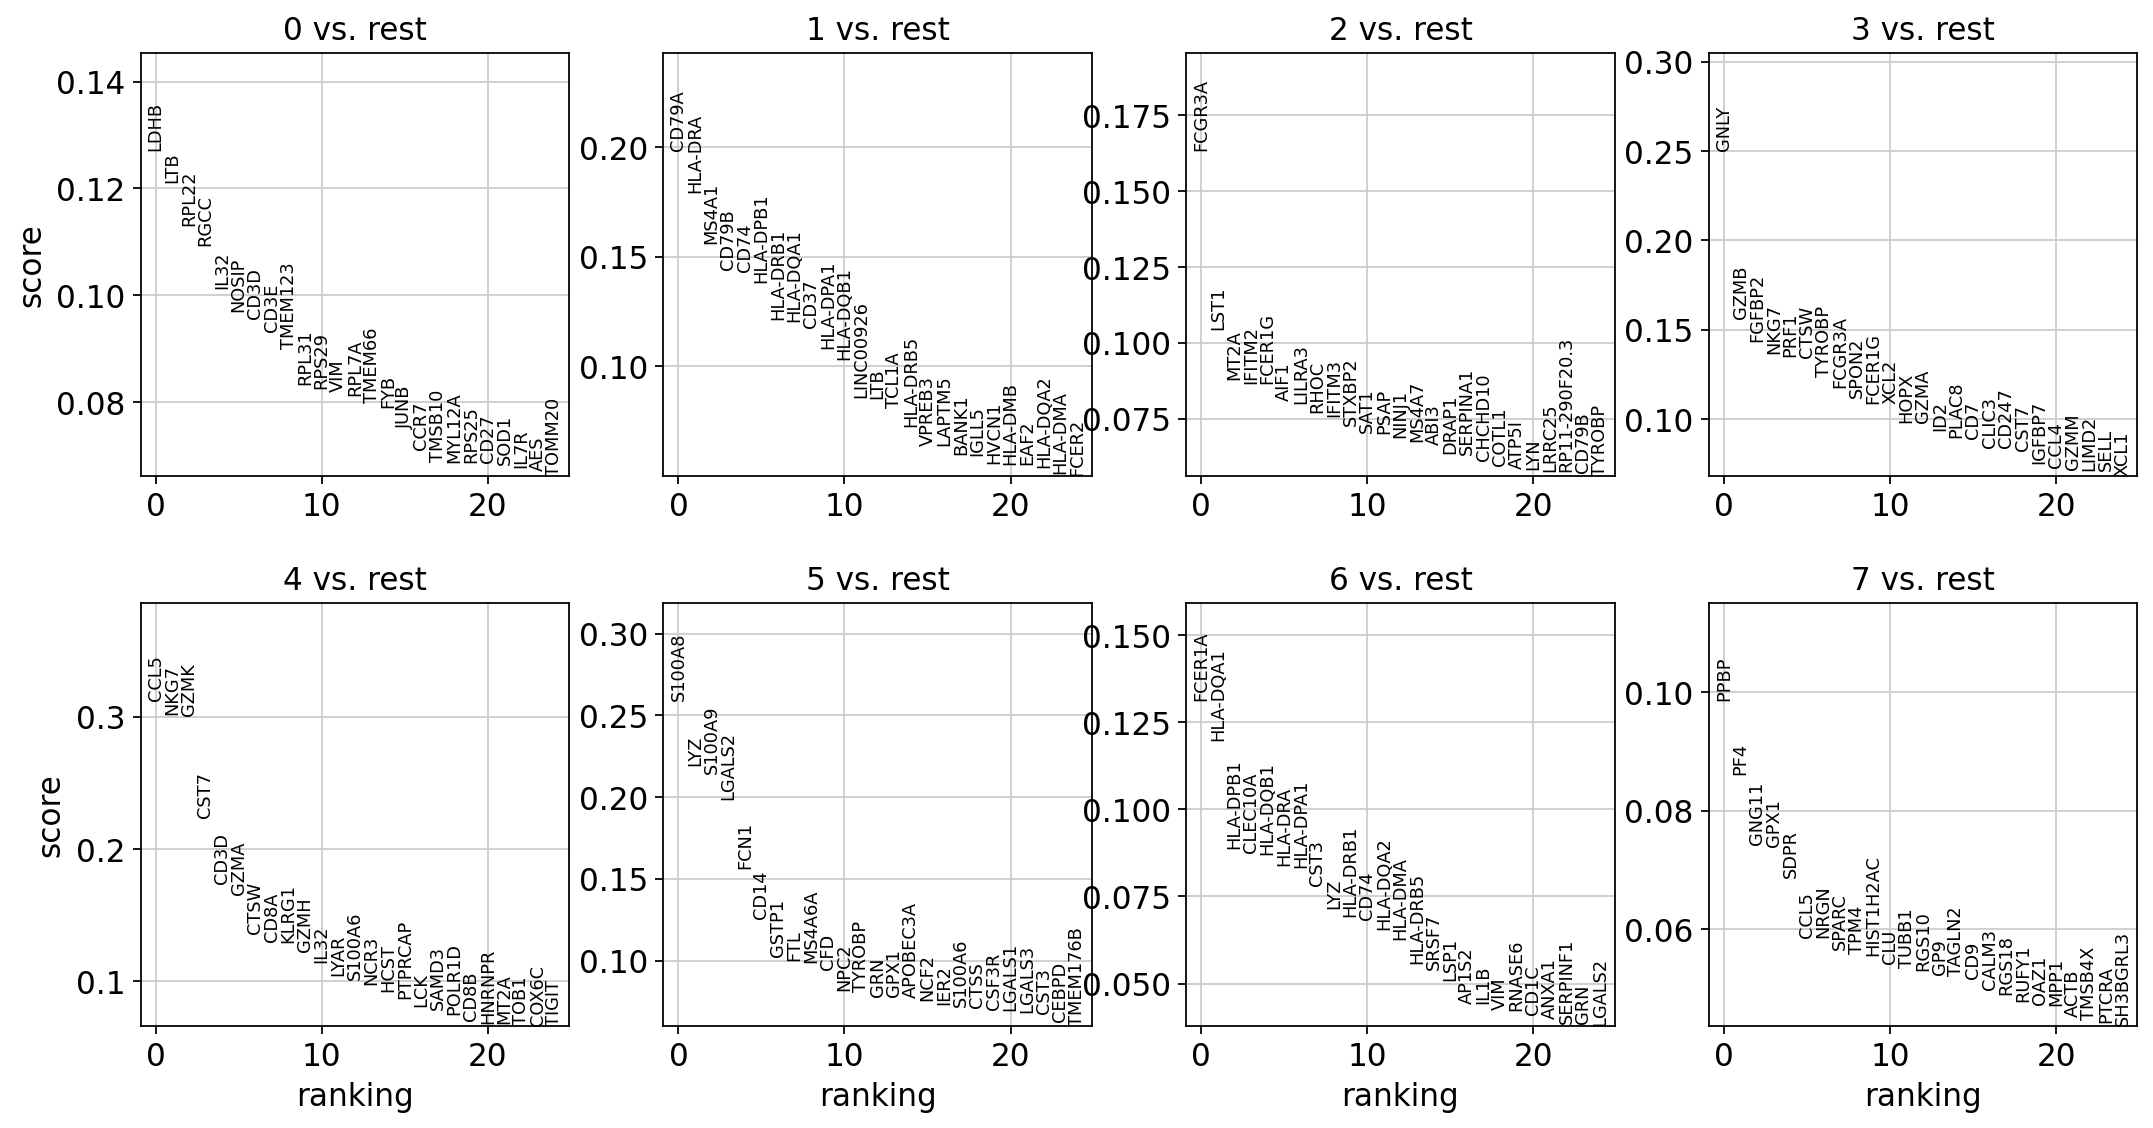

In [153]:
sc.tl.rank_genes_groups(adata, "leiden", method="logreg", max_iter=1000)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)

With the exceptions of IL7R, which is only found by the t-test and FCER1A, which is only found by the other two appraoches, all marker genes are recovered in all approaches.

In [164]:
marker_genes = [
    *["IL7R", "CD79A", "MS4A1", "CD8A", "CD8B", "LYZ", "CD14"],
    *["LGALS3", "S100A8", "GNLY", "NKG7", "KLRB1"],
    *["FCGR3A", "MS4A7", "FCER1A", "CST3", "PPBP"],
]

In [166]:
adata = sc.read(results_file)
pd.DataFrame(adata.uns["rank_genes_groups"]["names"]).head(5)

,0,1,2,3,4,5,6,7
0,RPS12,CD74,LST1,NKG7,CCL5,LYZ,HLA-DPA1,PF4
1,LDHB,CD79A,FCER1G,GZMB,NKG7,S100A9,HLA-DPB1,SDPR
2,RPS25,HLA-DRA,AIF1,GNLY,CST7,S100A8,HLA-DRA,GNG11
3,RPS27,CD79B,COTL1,CTSW,B2M,TYROBP,HLA-DRB1,PPBP
4,RPS6,HLA-DPB1,FCGR3A,PRF1,GZMA,FTL,CD74,NRGN


Get a table with the scores and groups.

In [169]:
result = adata.uns["rank_genes_groups"]
groups = result["names"].dtype.names
pd.DataFrame(
    {
        f"{group}_{key[:1]}": result[key][group]
        for group in groups
        for key in ["names", "pvals"]
    }
).head(5)

,0_n,0_p,1_n,1_p,2_n,2_p,3_n,3_p,4_n,4_p,5_n,5_p,6_n,6_p,7_n,7_p
0,RPS12,4.167598e-226,CD74,2.487145e-183,LST1,4.985426e-88,NKG7,3.591782e-93,CCL5,4.062586e-126,LYZ,2.844372e-249,HLA-DPA1,5.422417e-21,PF4,4.722886e-10
1,LDHB,1.794807e-223,CD79A,1.679730e-170,FCER1G,1.449472e-84,GZMB,2.033412e-87,NKG7,1.528118e-110,S100A9,2.654880e-246,HLA-DPB1,7.591860e-21,SDPR,4.733899e-10
2,RPS25,4.659461e-204,HLA-DRA,6.935111e-167,AIF1,5.833547e-83,GNLY,8.130223e-85,CST7,1.332168e-85,S100A8,8.731315e-238,HLA-DRA,1.306768e-19,GNG11,4.733899e-10
3,RPS27,9.438482e-192,CD79B,2.569135e-154,COTL1,1.261406e-81,CTSW,6.944632e-84,B2M,8.615108e-79,TYROBP,9.809633e-221,HLA-DRB1,1.865104e-19,PPBP,4.744938e-10
4,RPS6,5.767118e-188,HLA-DPB1,3.577195e-148,FCGR3A,4.610698e-77,PRF1,1.621421e-83,GZMA,1.480430e-78,FTL,3.676035e-215,CD74,5.853161e-19,NRGN,4.800511e-10


**Compare to a single cluster:**

ranking genes
    finished (0:00:01)


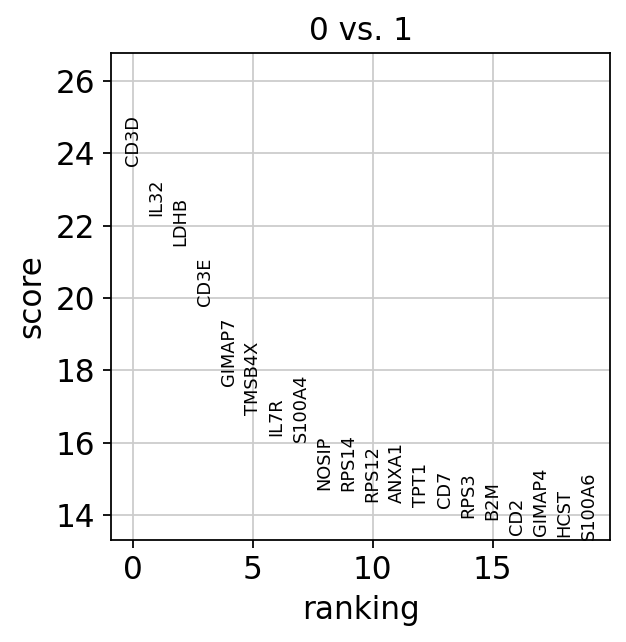

In [172]:
sc.tl.rank_genes_groups(adata, "leiden", groups=["0"], reference="1", method="wilcoxon")
sc.pl.rank_genes_groups(adata, groups=["0"], n_genes=20)

/home/mahendra/anaconda3/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


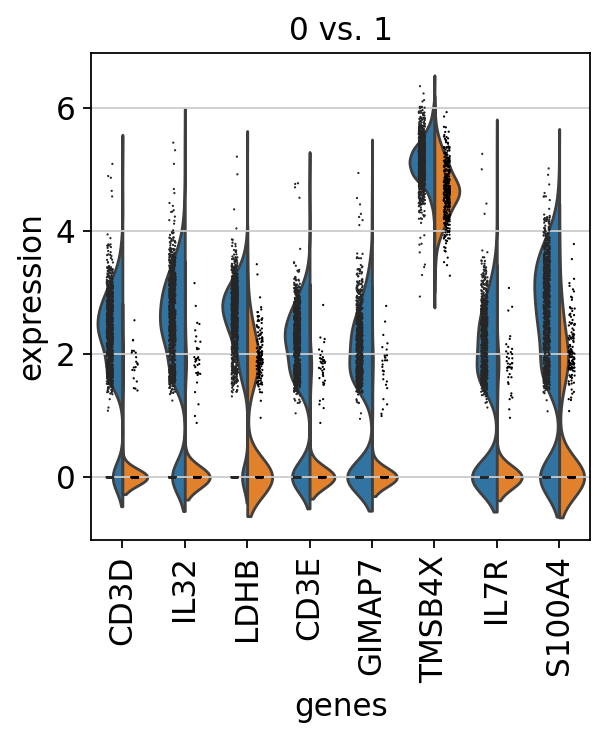

In [175]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

In [177]:
adata = sc.read(results_file)

/home/mahendra/anaconda3/lib/python3.12/site-packages/scanpy/plotting/_tools/__init__.py:1320: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  _ax.set_xticklabels(new_gene_names, rotation="vertical")


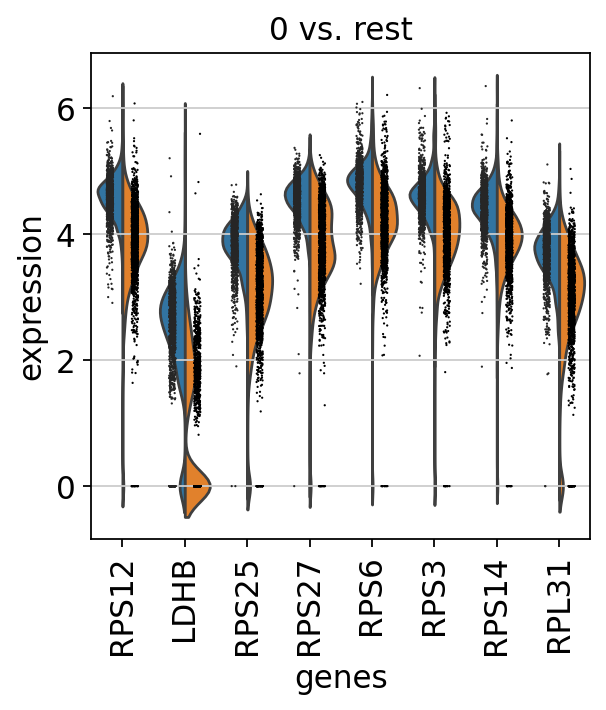

In [179]:
sc.pl.rank_genes_groups_violin(adata, groups="0", n_genes=8)

**If you want to compare a certain gene across groups, use the following**

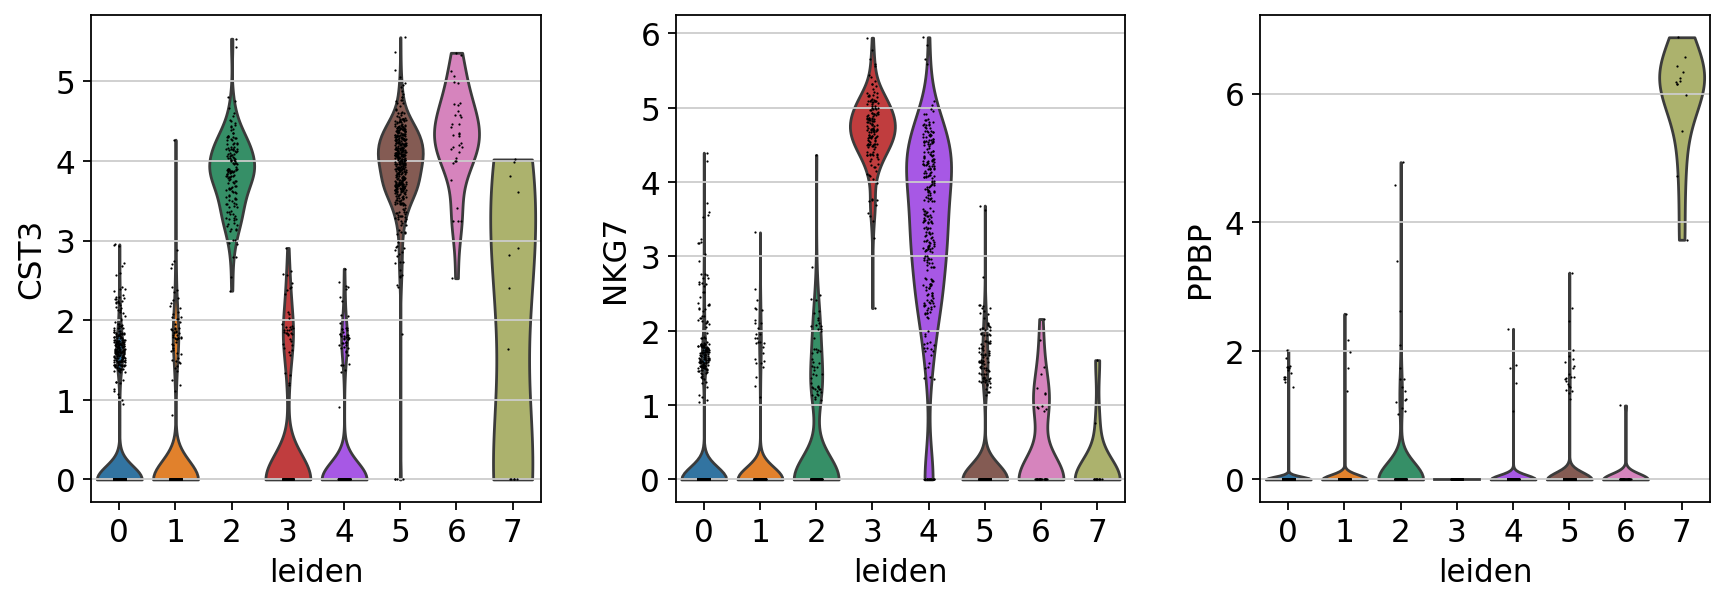

In [182]:
sc.pl.violin(adata, ["CST3", "NKG7", "PPBP"], groupby="leiden")

In [184]:
new_cluster_names = [
    "CD4 T",
    "B",
    "FCGR3A+ Monocytes",
    "NK",
    "CD8 T",
    "CD14+ Monocytes",
    "Dendritic",
    "Megakaryocytes",
]
adata.rename_categories("leiden", new_cluster_names)

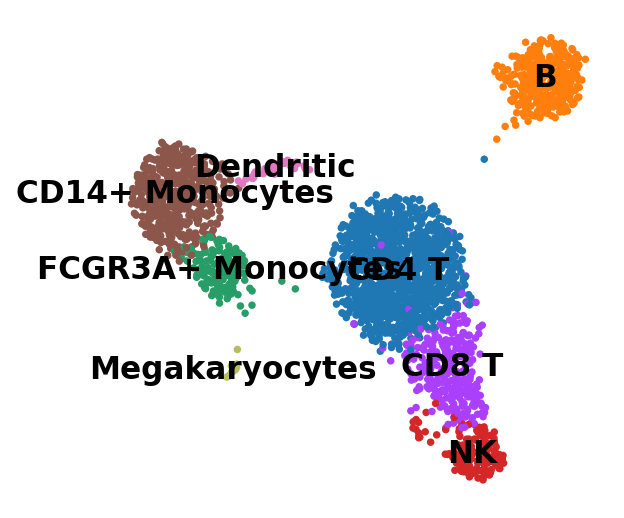

In [186]:
sc.pl.umap(
    adata, color="leiden", legend_loc="on data", title="", frameon=False, save=".pdf"
)

**Now that we annotated the cell types, let us visualize the marker genes**

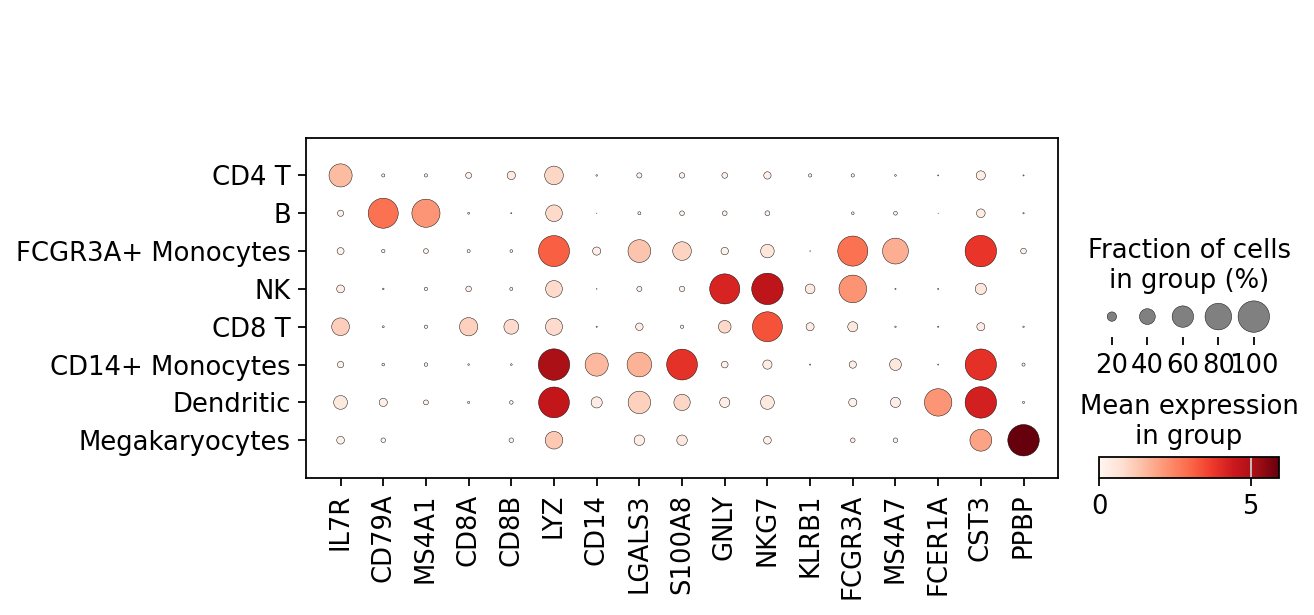

In [189]:
sc.pl.dotplot(adata, marker_genes, groupby="leiden");

**There is also a very compact violin plot**

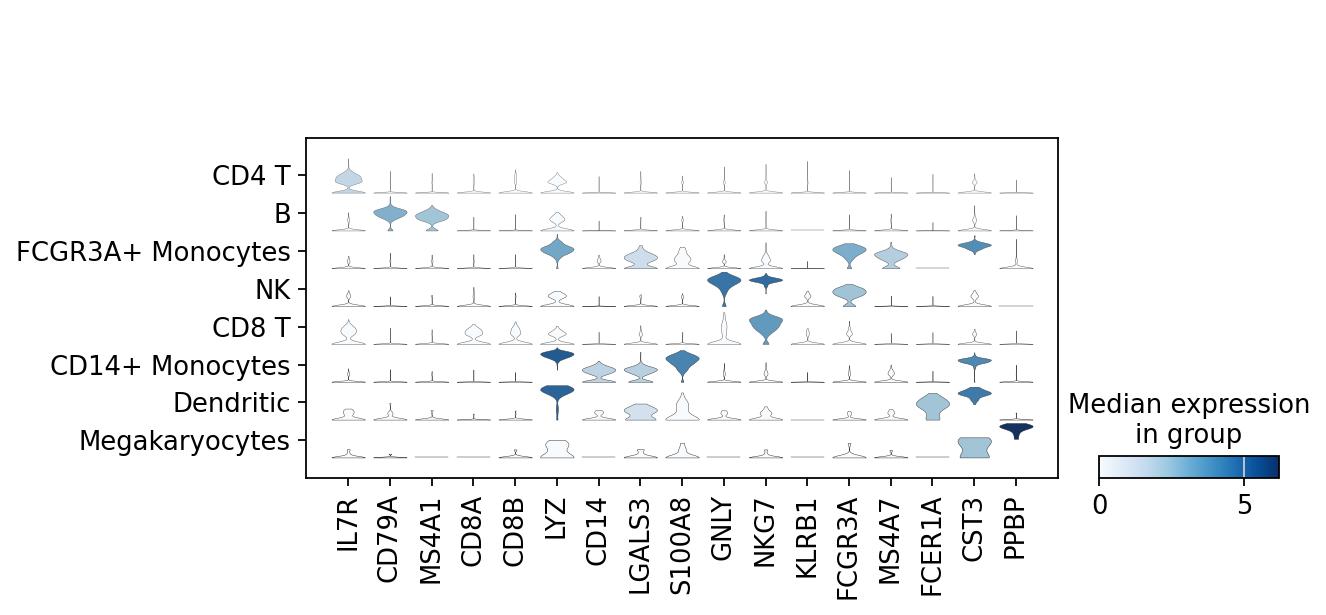

In [192]:
sc.pl.stacked_violin(adata, marker_genes, groupby="leiden");

In [196]:
# `compression='gzip'` saves disk space, and slightly slows down writing and subsequent reading
adata.write(results_file, compression="gzip")

[Reference 1 ](https://scanpy.readthedocs.io/en/stable/index.html) **|**
[Reference 2 ](https://scanpy-tutorials.readthedocs.io/en/latest/index.html) **|**
[Reference 3 ](https://satijalab.org/seurat/articles/pbmc3k_tutorial.html) 



<div align="right">
Name: Mahendra | PhD-Scholar | CLS,MU
</div>